In [97]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.enable('default')
import plotly.express as px
import pycountry

In [98]:
df = pd.read_csv('agrofood_co2_emission_cleaned.csv')
df = df.convert_dtypes()

print("columns:\n\n", df.columns, "\n\n")
print("description:\n\n", df.describe())


columns:

 Index(['Area', 'Year', 'Savanna fires', 'Forest fires', 'Crop Residues',
       'Rice Cultivation', 'Drained organic soils (CO2)',
       'Pesticides Manufacturing', 'Food Transport', 'Forestland',
       'Net Forest conversion', 'Food Household Consumption', 'Food Retail',
       'On-farm Electricity Use', 'Food Packaging',
       'Agrifood Systems Waste Disposal', 'Food Processing',
       'Fertilizers Manufacturing', 'IPPU', 'Manure applied to Soils',
       'Manure left on Pasture', 'Manure Management', 'Fires in organic soils',
       'Fires in humid tropical forests', 'On-farm energy use',
       'Rural population', 'Urban population', 'Total Population - Male',
       'Total Population - Female', 'total_emission', 'Average Temperature °C',
       'Total Population', 'Temperature Category', 'Population Size'],
      dtype='object') 


description:

              Year  Savanna fires  Forest fires  Crop Residues  \
count      6965.0         6965.0        6965.0         6

In [99]:
natural_sources = [
    "Savanna fires", "Forest fires", "Crop Residues", "Rice Cultivation",
    "Drained organic soils (CO2)", "Manure applied to Soils", "Manure left on Pasture",
    "Fires in organic soils", "Fires in humid tropical forests"
]

manmade_sources = [
    "Pesticides Manufacturing", "Food Transport", "Food Household Consumption",
    "Food Retail", "On-farm Electricity Use", "Food Packaging",
    "Agrifood Systems Waste Disposal", "Food Processing", "Fertilizers Manufacturing",
    "IPPU", "Manure Management", "On-farm energy use"
]

df_natural = df[["Year"] + natural_sources].set_index("Year")
df_manmade = df[["Year"] + manmade_sources].set_index("Year")

total_natural = df[natural_sources].sum()
total_manmade = df[manmade_sources].sum()

top5_natural = total_natural.sort_values(ascending=False).head(5).index.tolist()
top5_manmade = total_manmade.sort_values(ascending=False).head(5).index.tolist()

df_natural_top5_grouped = df.groupby('Year')[top5_natural].sum()
df_manmade_top5_grouped = df.groupby('Year')[top5_manmade].sum()

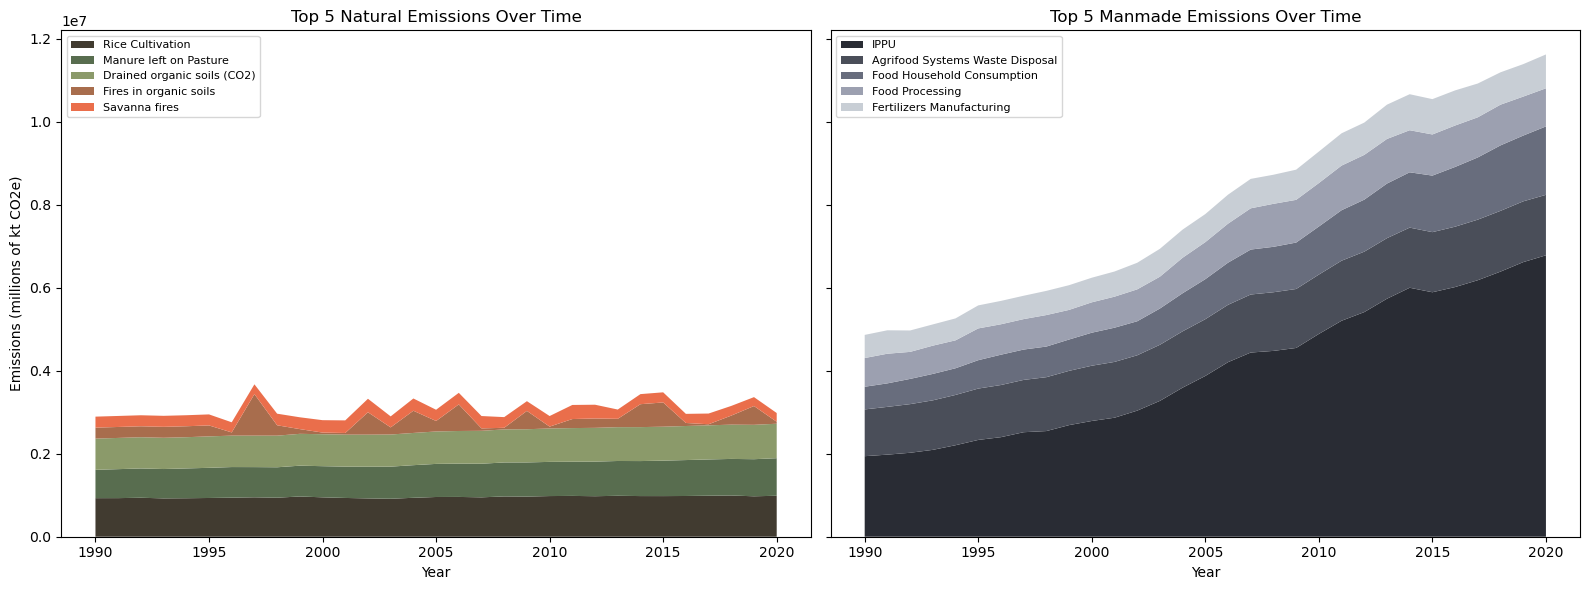

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

axes[0].stackplot(
    df_natural_top5_grouped.index,
    *[df_natural_top5_grouped[col] for col in top5_natural],
    labels=top5_natural,
    colors=['#ea6e4b', '#a86d4d', '#8b9a6a', '#586d4f', '#413b30'][::-1]
)
axes[0].set_title("Top 5 Natural Emissions Over Time")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Emissions (millions of kt CO2e)")
axes[0].legend(loc='upper left', fontsize=8)

axes[1].stackplot(
    df_manmade_top5_grouped.index,
    *[df_manmade_top5_grouped[col] for col in top5_manmade],
    labels=top5_manmade,
    colors=['#292c34', '#4a4e59', '#686d7d', '#9ca0b0', '#c8ced5']
)
axes[1].set_title("Top 5 Manmade Emissions Over Time")
axes[1].set_xlabel("Year")
axes[1].legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [101]:
def country_to_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None

In [102]:
df_choropleth = df.groupby(['Area', 'Year'], as_index=False)['total_emission'].sum()
df_choropleth.rename(columns={'Area': 'Country'}, inplace=True)
df_choropleth['ISO3'] = df_choropleth['Country'].apply(country_to_iso3)
missing_iso = df_choropleth[df_choropleth['ISO3'].isnull()]['Country'].unique()
print("Missing ISO3 codes for:", missing_iso)

Missing ISO3 codes for: <StringArray>
[                'Belgium-Luxembourg',   'Bolivia (Plurinational State of)',
                    'Channel Islands',               'China, Hong Kong SAR',
                   'China, Macao SAR',          'China, Taiwan Province of',
                    'China, mainland',                     'Czechoslovakia',
   'Democratic Republic of the Congo',                       'Ethiopia PDR',
                           'Holy See',         'Iran (Islamic Republic of)',
   'Micronesia (Federated States of)',       'Netherlands (Kingdom of the)',
      'Netherlands Antilles (former)',    'Pacific Islands Trust Territory',
                          'Palestine',                  'Republic of Korea',
              'Serbia and Montenegro',                     'Sudan (former)',
                               'USSR',       'United States Virgin Islands',
 'Venezuela (Bolivarian Republic of)',          'Wallis and Futuna Islands',
                       'Yugoslav SFR']

In [103]:
manual_iso3_fixes = {
    'Belgium-Luxembourg': 'BEL',
    'Bolivia (Plurinational State of)': 'BOL',
    'Channel Islands': 'GBR',
    'China, Hong Kong SAR': 'HKG',
    'China, Macao SAR': 'MAC',
    'China, Taiwan Province of': 'TWN',
    'China, mainland': 'CHN',
    'Czechoslovakia': 'CZE', 
    'Democratic Republic of the Congo': 'COD',
    'Ethiopia PDR': 'ETH',
    'Holy See': 'VAT',
    'Iran (Islamic Republic of)': 'IRN',
    'Micronesia (Federated States of)': 'FSM',
    'Netherlands (Kingdom of the)': 'NLD',
    'Netherlands Antilles (former)': 'ANT',
    'Pacific Islands Trust Territory': 'PCN',
    'Palestine': 'PSE',
    'Republic of Korea': 'KOR',
    'Serbia and Montenegro': 'SRB',
    'Sudan (former)': 'SDN',
    'USSR': 'RUS',
    'United States Virgin Islands': 'VIR',
    'Venezuela (Bolivarian Republic of)': 'VEN',
    'Wallis and Futuna Islands': 'WLF',
    'Yugoslav SFR': 'YUG'
}

df_choropleth['ISO3'] = df_choropleth['Country'].apply(country_to_iso3)

df_choropleth['ISO3'] = df_choropleth.apply(
    lambda row: manual_iso3_fixes.get(row['Country'], row['ISO3']),
    axis=1
)

still_missing = df_choropleth[df_choropleth['ISO3'].isnull()]['Country'].unique()
print("Still missing ISO3 codes:", still_missing)

Still missing ISO3 codes: <StringArray>
[]
Length: 0, dtype: string


In [104]:
fig = px.choropleth(
    df_choropleth,
    locations='ISO3',
    color='total_emission',
    hover_name='Country',
    animation_frame='Year',
    color_continuous_scale='YlOrRd',
    range_color=(0, df_choropleth['total_emission'].max()),
    title='Agricultural CO₂ Emissions by Country Over Time'
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title='Total Emissions<br>(kt CO₂e)')
)

fig.show()

In [105]:
df_bubble_clean = df.copy()

df_bubble_clean['Total Population'] = df_bubble_clean['Rural population'] + df_bubble_clean['Urban population']

df_bubble_clean = df_bubble_clean[
    (df_bubble_clean['total_emission'] > 0) &
    (df_bubble_clean['Total Population'] > 0)
].copy()

df_bubble_clean.rename(columns={'Area': 'Country'}, inplace=True)

In [106]:
fig = px.scatter(
    df_bubble_clean,
    x='Total Population',
    y='total_emission',
    size='total_emission',
    color='Country',
    animation_frame='Year',
    hover_name='Country',
    size_max=60,
    title='Agricultural Emissions vs Population Over Time',
    labels={
        'total_emission': 'Total Emissions (kt CO₂e)',
        'Total Population': 'Total Population'
    }
)

fig.update_layout(
    xaxis_title='Total Population (Rural + Urban)',
    yaxis_title='Agricultural Emissions (kt CO₂e)',
    showlegend=False
)

fig.show()

In [107]:
# Check for any rows with negative emissions
negative_emissions = df[df['total_emission'] < 0]

# Check for massive forestland losses
extreme_forestland = df[df['Forestland'] < -500_000]

# Check for crazy fire values
extreme_fires = df[df['Fires in organic soils'] > 100_000]

# Print summaries
print("Negative emissions:\n", negative_emissions[['Area', 'Year', 'total_emission']])
print("Extreme forestland losses:\n", extreme_forestland[['Area', 'Year', 'Forestland']])
print("Extreme organic soil fires:\n", extreme_fires[['Area', 'Year', 'Fires in organic soils']])


Negative emissions:
           Area  Year  total_emission
707     Bhutan  1990    -1892.181051
708     Bhutan  1991    -1851.638551
709     Bhutan  1992    -1868.130806
710     Bhutan  1993    -1873.788306
711     Bhutan  1994    -1829.281106
...        ...   ...             ...
6782  Viet Nam  1995   -10319.221011
6783  Viet Nam  1996    -7818.504396
6784  Viet Nam  1997    -5595.490499
6785  Viet Nam  1998    -3168.626171
6786  Viet Nam  1999    -2022.531927

[238 rows x 3 columns]
Extreme forestland losses:
                           Area  Year   Forestland
840                     Brazil  2001 -504292.9573
841                     Brazil  2002 -504292.9573
842                     Brazil  2003 -504292.9573
843                     Brazil  2004 -504292.9573
844                     Brazil  2005 -504292.9573
...                        ...   ...          ...
6599  United States of America  1998 -520573.1593
6600  United States of America  1999 -520573.1593
6601  United States of America  2

In [108]:
# Identify all countries with any negative total_emission values
neg_emit_df = df[df['total_emission'] < 0]

# Group by country and count occurrences
neg_emit_summary = neg_emit_df['Area'].value_counts().reset_index()
neg_emit_summary.columns = ['Country', 'Negative Emission Years']

# Display all unique countries with negative emissions
print("Countries with negative emissions")
print(neg_emit_summary)


Countries with negative emissions
                  Country  Negative Emission Years
0                Bulgaria                       30
1                   Chile                       30
2                  Bhutan                       21
3                  Latvia                       19
4                Slovenia                       19
5      Russian Federation                       19
6                 Finland                       16
7                 Uruguay                       11
8              Costa Rica                       10
9                Viet Nam                       10
10                Georgia                        9
11            New Zealand                        8
12  Serbia and Montenegro                        5
13             Montenegro                        5
14                  Ghana                        5
15               Malaysia                        5
16                Romania                        5
17                 Serbia                       

In [109]:
df[df['Area'] == 'Bhutan']['total_emission'].head(40)

707   -1892.181051
708   -1851.638551
709   -1868.130806
710   -1873.788306
711   -1829.281106
712   -1769.604806
713   -1767.287106
714   -1762.518106
715   -1740.699406
716   -1699.286906
717   -1763.407806
718   -2300.757463
719   -1892.734502
720   -2199.137166
721   -1862.999848
722   -1832.828102
723   -1720.223106
724   -1620.490806
725   -2123.900366
726   -1884.023066
727   -1491.925948
728    3602.920834
729    4041.163394
730    3967.595794
731    3623.771834
732    3769.985234
733    3802.799134
734    3836.081234
735    3802.132834
736    4282.132098
737    3994.139134
Name: total_emission, dtype: Float64